# Movie Review Crawling & WordCloud 

## 학습목표
- 영화 리뷰 데이터 수집 (블로그)
- 수집한 데이터를 시각화하기 위한, 전처리
- 워드클라우드를 생성

### 영화리뷰 프로세스
1. 영화 리뷰에 있는 블로그들의 주소 수집
2. 블로그 안으로 들어가서 리뷰내용 수집하기 (첫번째 블로그에서 수집)
3. 여러개의 블로그 리뷰내용 수집
4. 수집한 텍스트데이터 전처리
5. 워드클라우드 생성하기

#### 1. 영화 리뷰에 있는 블로그들의 주소 수집

In [ ]:
!pip install lxml

In [ ]:
import requests as req
from bs4 import BeautifulSoup as bs
import re # 정규표현식 
import pandas as pd

In [ ]:
url = "https://search.naver.com/search.naver?sm=tab_hty.top&where=nexearch&ssc=tab.nx.all&query=%EC%95%84%EB%B0%94%ED%83%803+%EB%A6%AC%EB%B7%B0&oquery=%EC%95%84%EB%B0%94%ED%83%802+%EB%A6%AC%EB%B7%B0&tqi=jUsNTwqos5ossi2ZKPZ-342894&ackey=74e97f8t"
res = req.get(url)

In [ ]:
res

In [ ]:
soup = bs(res.text,'lxml')

In [ ]:
link = soup.select("dt.list_title>a")
link[0].get('href')

- a 태그가 경로정보 저장하고 있음
- 절대경로에서 정보를 찾는 방법
  - `a`태그에서 copy-copy selector를 통해 절대경로를 찾아올 수 있음
```
nth-child() 
```
- 동일한 li 태그들일 때 nth-child(1),nth-child(2) 를 통해 같은 li 들끼리 찾아올 수 있음

In [ ]:
len(soup.select("dt.list_title>a"))

In [ ]:
href_list = []
for i in range(len(link)):
    l = link[i].get('href')
    href_list.append(l)

In [ ]:
href_list

In [ ]:
soup.select("div.review_info._ellipsis") # 이 키워드로 불러와도 상관없음!

- 블로그 제목을 블로그안에서 가져오기 (네이버 웹상에서는 짤려서..)

In [ ]:
url1 = 'https://blog.naver.com/블로그이름₩₩₩'
req.get(url1)

In [ ]:
res1 = req.get(href_list[0])
soup1 = bs(res1.text,'lxml')
soup1

In [ ]:
soup1.select("div.se-main-container")

In [ ]:
soup1.select("#post-view224115606045 > div > div.se-main-container")

- 위의 두 태그 모두 아무 내용이 나오지 않음... > 아이프레임 개념 필요

##### 아이프레임
- 아이프레임 : 다른곳에 내용을 저장해놓고, 현재페이지에서는 데이터를 `보여주기만` 함.
  - 모든 실제데이터를 페이지상에 업로드 해놓으면, 페이지 자체가 무거워짐

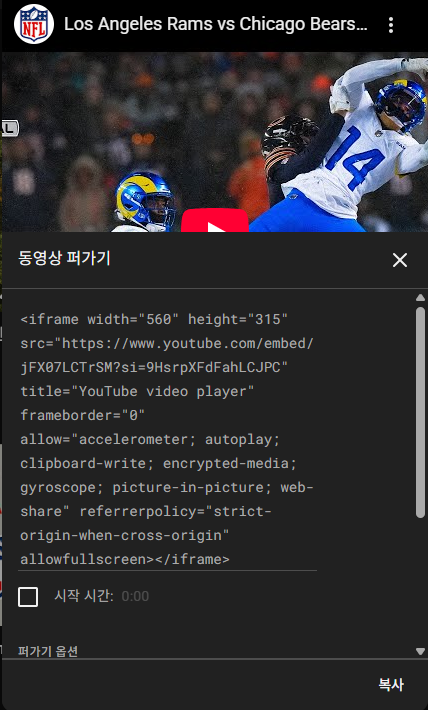

유튜브 역시도 아이프레임

- src가 가지고 있는 url이 가지고 있는게 원본 데이터가 저장된 곳의 주소
  - 아이프레임 자체는 열리지 않음 > 웹페이지의 표준 규칙을 가지고 있지 않기때문에..

  -  현재 뷰 만 보여주는 주소는 블로그 뒷부분 주소가 연하게 되어있음.
  -  연하게 작성된 부분을 지우고 src의 주소를 붙여넣으면 원본데이터가 저장된 곳으로 이동할 수 있음

##### 선생님 설명
**아이프레임**
- 하나의 페이지에 많은 양의 데이터가 저장되어 있으면 페이지가 무거워짐 > 속도 저하
- 데이터는 다른 저장 사이트에 저장해두고 현재 피에지에서는 보여주기만 하는 형태로 출력
- 데이터 수집을 위해서 실제 데이터가 저장된 공간으로 접근
- ex) 블로그, 카페, 지식인, 지도


- 실제 데이터의 주소
  - 메인주소(진한 검정색) + head가 가진 src -> 실제 블로그 주소 생성
  - blog.naver.com + src
- 매번 달라지는 src 주소를 가져올 수 없음 > src(속성) 추출해오기 > get함수를 통해 가져와야함

In [ ]:
# src 추출
src = soup1.select_one("iframe#mainFrame").get('src')
# 실제주소 완성하기
# 메인주소 + src
blog_url = "https://blog.naver.com" + src

#### 2. 블로그 안으로 들어가서 리뷰내용 수집하기 (첫번재 블로그에서 수집)


In [ ]:
res2 = req.get(blog_url)
soup2 = bs(res2.text,'lxml')

In [ ]:
# blog_url 페이지 에서 리뷰내용 수집

In [ ]:
soup2.select("div.se-main-container")[0].text

- 정규표현식을 활용한 텍스트 데이터 전처리
  - re
  - 정규표현식 : 문자열 내에서 특정규칙(패턴)을 찾아 변경하는 도구

| 구성요소                  | 의미                       |
| --------------------- | ------------------------ |
| `r"..."`              | Raw string — 이스케이프 문자 무시 |
| `[^ ... ]`            | 괄호 안 문자 **제외한** 문자들      |
| `0-9`                 | 숫자                       |
| `가-힣`                 | 모든 한글                    |
| `?.!,¿`               | 허용할 문장 부호                |
| `+`                   | 하나 이상 연속된 구간             |
| `re.sub(..., " ", w)` | 매칭된 부분을 공백으로 치환          |

In [ ]:
# 문자열 전처리함수 -> 숫자, 문자, (?,!) 제외하고 공백으로 대체

def preprocess_sentence_kr(w):
  w = w.strip()
  w = re.sub(r"[^0-9가-힣?.!,¿]+", " ", w) 
  w = w.strip() 
  return w
 

```
re.sub(pattern, replacement, string)
```
- sub함수 사용법

In [ ]:
content = soup2.select("div.se-main-container")[0].text
preprocess_sentence_kr(content)

#### 3. 여러개의 블로그 리뷰내용 수집


In [ ]:
from tqdm import tqdm

>하나의 페이지를 먼저 해본 다음, 그 다음으로 for문으로 구성하자

In [ ]:
# open 함수를 사용하여 파일 열어서 초기화
f = open('./data/movie_review.txt','w',encoding = 'utf-8')


review = []
for i in tqdm(range(len(href_list))):
    res1 = req.get(href_list[i])
    soup1 = bs(res1.text,'lxml')
    soup1

    # iframe src 속성값을 추출하여 실제 블로그 주소 생성
    src = soup1.select_one("iframe#mainFrame").get('src')
    # 실제주소 작성
    blog_url = "https://blog.naver.com" + src

    # 실제 내용이 들어있는 페이지 정보 받아오기
    res2 = req.get(blog_url)
    soup2 = bs(res2.text,'lxml')

    # 본문 내용 수집
    content = soup2.select("div.se-main-container")[0].text
    final_content = preprocess_sentence_kr(content)
    f.write(final_content) # 내용을 f에 써주기
f.close() #파일 닫기

In [ ]:
f = open('./data/movie_review.txt','r',encoding = 'utf-8')

In [ ]:
review = f.readline()
f.close()

- 열고 읽었으면 꼭 닫아 줘야함!!

#### 4. 수집한 텍스트데이터 전처리

In [ ]:
review

- 현재 데이터는 하나의 긴 문장이므로 "토큰화" 가 필요
- 한국어는 조사와 어미가 발달했음
  - ex) "설리가" / "설리는" > 두개를 서로 다른의미로 인식
  - 그래서 형태소로 분석해야함 > 형태소 분석기

- 형태소 분석기를 활용하여 문서 > 토큰화 > 단어단위 변경
  - kiwi 형태소 분석기 사용

In [ ]:
!pip install kiwipiepy

- 워드클라우드 생성 도구 설치

In [ ]:
!pip install wordcloud

In [ ]:
from kiwipiepy import Kiwi as kw # 키위 형태소 분석기
from wordcloud import WordCloud as wc # 워드클라우드 생성 도구
from collections import Counter # 단어 횟수 세어주는 도구
import matplotlib.pyplot as plt # 시각화 도구

In [ ]:
# 도구 객체 생성
kiwi = Kiwi()

In [ ]:
# 토큰화
token = kiwi.tokenize(review)

In [ ]:
token

- 'NNG' : 일반 명사를 의미
- token의 리스트를 돌면서, 태그가 NNG인 form을 

In [ ]:
nng_list = []
for t in token:
    if "NNG" in t.tag:
        nng_list.append(t.form)
    

In [ ]:
nng_list = []
for t in token:
    if t[1] == 'NNG':
        nng_list.append(t[0])

In [ ]:
nng_list

In [ ]:
# 간편하게 리스트에 데이터를 누적하는 방법
# 리스트컴프리헨션 [실행문 반복문 조건]
nng_list = [t.form for t in token if t.tag == 'NNG']

In [ ]:
nng_list[0]

In [ ]:
counter = Counter(nng_list)
counter

In [ ]:
# 상위 100개만 추출
top_100 = counter.most_common(100)

#### 5. 워드클라우드 생성하기

In [ ]:
wc = WordCloud(
    font_path='C:/Windows/Fonts/malgunbd.ttf',
    background_color='white'    
).generate_from_frequencies(dict(top_100))
plt.imshow(wc)
plt.axis('off')
plt.show()

**리뷰 데이터 활용할 때 주로 사용!!!!!**

### 개인적인 연습코드
- 천번째 for문을 통해 실제 데이터 접근할 수 있는 데이터 주소 만들기
- 두번째 for문을 통해 실제 주소에 접근해서 리뷰 데이터 불러오기

In [ ]:
from tqdm import tqdm

In [ ]:
real_list = []
review_list = []
for lst in tqdm(href_list):
    soup1 = bs(req.get(lst).text,'lxml')
    src = soup1.select_one("iframe#mainFrame").get('src')
    blog_url = "https://blog.naver.com" + src
    real_list.append(blog_url)

    for l in real_list:
        res2 = req.get(l)
        soup2 = bs(res2.text,'lxml')
        content = soup2.select("div.se-main-container")[0].text
        review = preprocess_sentence_kr(content)
        review_list.append(review)

- for문 두개를 사용하면 잘못된 결과값 나옴.. > 뭐가 잘못되었을지 생각해보기..

In [ ]:
pd.DataFrame(review_list)